# Ejemplo 4: Implementación de modelos

Charla: Potenciando la Inteligencia Artificial con ROS y OpenVINO

Autor: Dr. Edgar Macías García

Human Robot Collaboration Group

Intel Labs

### **1. Instalar dependencias**

Frameworks de redes neuronales

In [ ]:
#Instalar pytorch
!pip install torch torchvision torchaudio

#Instalar onnx
!pip install onnx onnxruntime

#Instalar OpenVINO
!pip install openvino

Dependencias adicionales

In [ ]:
#Instalar gdown
!pip install gdown

Importar librerias

In [39]:
#Librerias estandar
import numpy as np
from PIL import Image
import gdown
import os

#Librerias de vision
import cv2

#Librerias de graficado
import matplotlib.pyplot as plt

#Librerias de frameworks
import torch
import torchvision.transforms
import onnx
import onnxruntime as ort
import openvino as ov

### **2.- Descargar modelo base de pytorch**

El repositorio siguiente contiene un modelo entrenado en el framework pytorch para detectar las articulaciones de las manos

In [ ]:
#Descargar repositorio
!git clone https://github.com/MengHao666/Minimal-Hand-pytorch

Cloning into 'Minimal-Hand-pytorch'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 336 (delta 65), reused 49 (delta 49), pack-reused 258 (from 1)
Receiving objects: 100% (336/336), 8.64 MiB | 19.22 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [ ]:
#Install repository dependences
!pip install einops
!pip install transforms3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.2 MB/s eta 0:00:00


Configurar repositorio

In [ ]:
#Establecer repositorio
os.chdir("/content/Minimal-Hand-pytorch")

In [ ]:
#Download additional packages
url = 'https://drive.google.com/uc?export=download&id=11q5mICavFrr9ZscH54YojD7E2x5Ggqjp'
output = 'mano_v1_2.zip'
gdown.download(url, output, quiet=False)

#Download trained weights
url = 'https://drive.google.com/uc?export=download&id=1uNQt3TveKDoNyQBfZ_uqsGYEXbtkG9fb'
output = 'my_results.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=11q5mICavFrr9ZscH54YojD7E2x5Ggqjp
From (redirected): https://drive.google.com/uc?export=download&id=11q5mICavFrr9ZscH54YojD7E2x5Ggqjp&confirm=t&uuid=93d854fd-c8cd-4835-a384-7870b371c0b3
To: /content/Minimal-Hand-pytorch/mano_v1_2.zip
100%|██████████| 175M/175M [00:04<00:00, 43.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1uNQt3TveKDoNyQBfZ_uqsGYEXbtkG9fb
From (redirected): https://drive.google.com/uc?export=download&id=1uNQt3TveKDoNyQBfZ_uqsGYEXbtkG9fb&confirm=t&uuid=f3498884-dd2c-453f-9bec-c0f82624b4c7
To: /content/Minimal-Hand-pytorch/my_results.zip
100%|██████████| 198M/198M [00:07<00:00, 26.5MB/s]


'my_results.zip'

In [ ]:
#Copiar y extraer modelos
!unzip mano_v1_2.zip
!unzip my_results.zip

Archive:  mano_v1_2.zip
   creating: mano_v1_2/
  inflating: mano_v1_2/.DS_Store     
  inflating: mano_v1_2/._.DS_Store   
  inflating: mano_v1_2/LICENSE.txt   
  inflating: mano_v1_2/__init__.py   
   creating: mano_v1_2/models/
  inflating: mano_v1_2/models/LICENSE.txt  
  inflating: mano_v1_2/models/MANO_LEFT.pkl  
  inflating: mano_v1_2/models/MANO_RIGHT.pkl  
  inflating: mano_v1_2/models/SMPLH_female.pkl  
  inflating: mano_v1_2/models/SMPLH_male.pkl  
  inflating: mano_v1_2/models/info.txt  
   creating: mano_v1_2/webuser/
  inflating: mano_v1_2/webuser/LICENSE.txt  
  inflating: mano_v1_2/webuser/README.txt  
  inflating: mano_v1_2/webuser/__init__.py  
   creating: mano_v1_2/webuser/hello_world/
  inflating: mano_v1_2/webuser/hello_world/MANO___hello_world.py  
  inflating: mano_v1_2/webuser/hello_world/MANO___render.py  
  inflating: mano_v1_2/webuser/hello_world/SMPL+H___hello_world.py  
  inflating: mano_v1_2/webuser/hello_world/SMPL+H___render.py  
  inflating: mano_v1_2/

In [ ]:
#Configurar modelos
!mkdir mano
!mv mano_v1_2/models mano/
!mv mano_v1_2/webuser mano/

In [ ]:
#Importar librerias adicionales
from model.detnet import detnet
from utils import func, bone, AIK, smoother
from utils import vis

### **3.- Funciones Auxiliares**

In [ ]:
#Convertir imagen a tensor de pytorch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.5, 0.5, 0.5], #Media de canal
        std=[1.0, 1.0, 1.0])  #Desviacion estandar de canal
])

Descargar imagen muestra

--2024-10-24 04:49:01--  https://www.mheducation.es/media/wysiwyg/Spain/Newsletter/Post/el-infinito-en-la-palma-de-la-mano-600.jpg
Resolving www.mheducation.es (www.mheducation.es)... 172.64.150.33, 104.18.37.223, 2606:4700:4400::ac40:9621, ...
Connecting to www.mheducation.es (www.mheducation.es)|172.64.150.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35853 (35K) [image/jpeg]
Saving to: ‘el-infinito-en-la-palma-de-la-mano-600.jpg’

el-infinito-en-la-p 100%[===================>]  35.01K  --.-KB/s    in 0.004s  

2024-10-24 04:49:01 (9.61 MB/s) - ‘el-infinito-en-la-palma-de-la-mano-600.jpg’ saved [35853/35853]



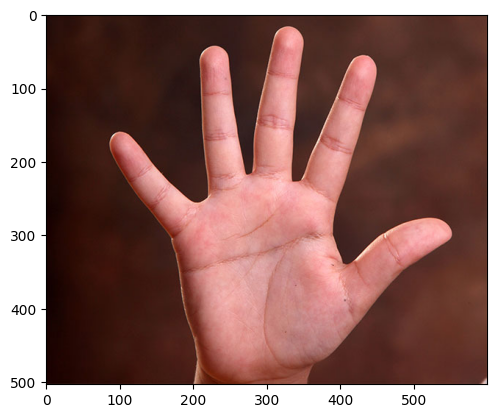

In [55]:
#Descargar imagen
!wget https://www.mheducation.es/media/wysiwyg/Spain/Newsletter/Post/el-infinito-en-la-palma-de-la-mano-600.jpg
!mv /content/Minimal-Hand-pytorch/el-infinito-en-la-palma-de-la-mano-600.jpg datasets/hand_test.jpg

#Abrir imagen
img1 = Image.open('datasets/hand_test.jpg').convert('RGB')

#Imprimir figura
plt.figure(1)
plt.imshow(img1)

### ***4.- Inferencia en Pytorch***

In [ ]:
#Inicializar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cargar modelo

In [ ]:
#Crear modelo
model = detnet()

#Cargar pesos
map_location = lambda storage, loc: storage
model.load_state_dict(
    torch.load("my_results/checkpoints/ckp_detnet_101.pth", map_location=map_location)
)

#Mover archivo a dispositivo
model.to(device)

detnet(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (block1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm

Preprocesamiento

In [56]:
#Redimensionar imagen
img1 = img1.resize((128, 128))

#Normalizar
img1t = pil_to_tensor(img1)
img1t = img1t[None, :, :, :]

Inferencia

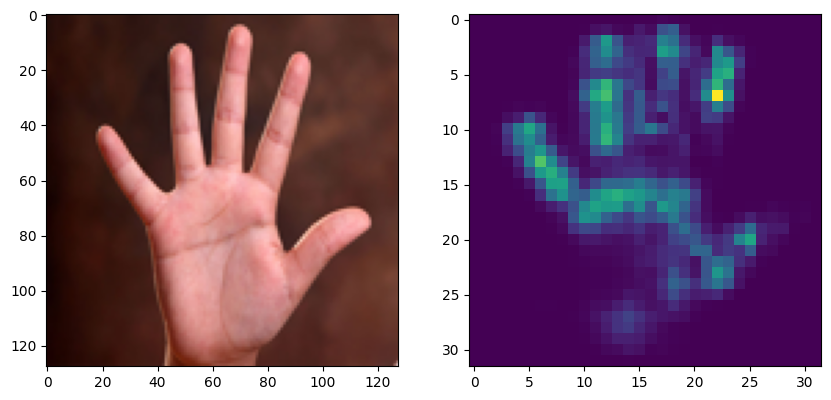

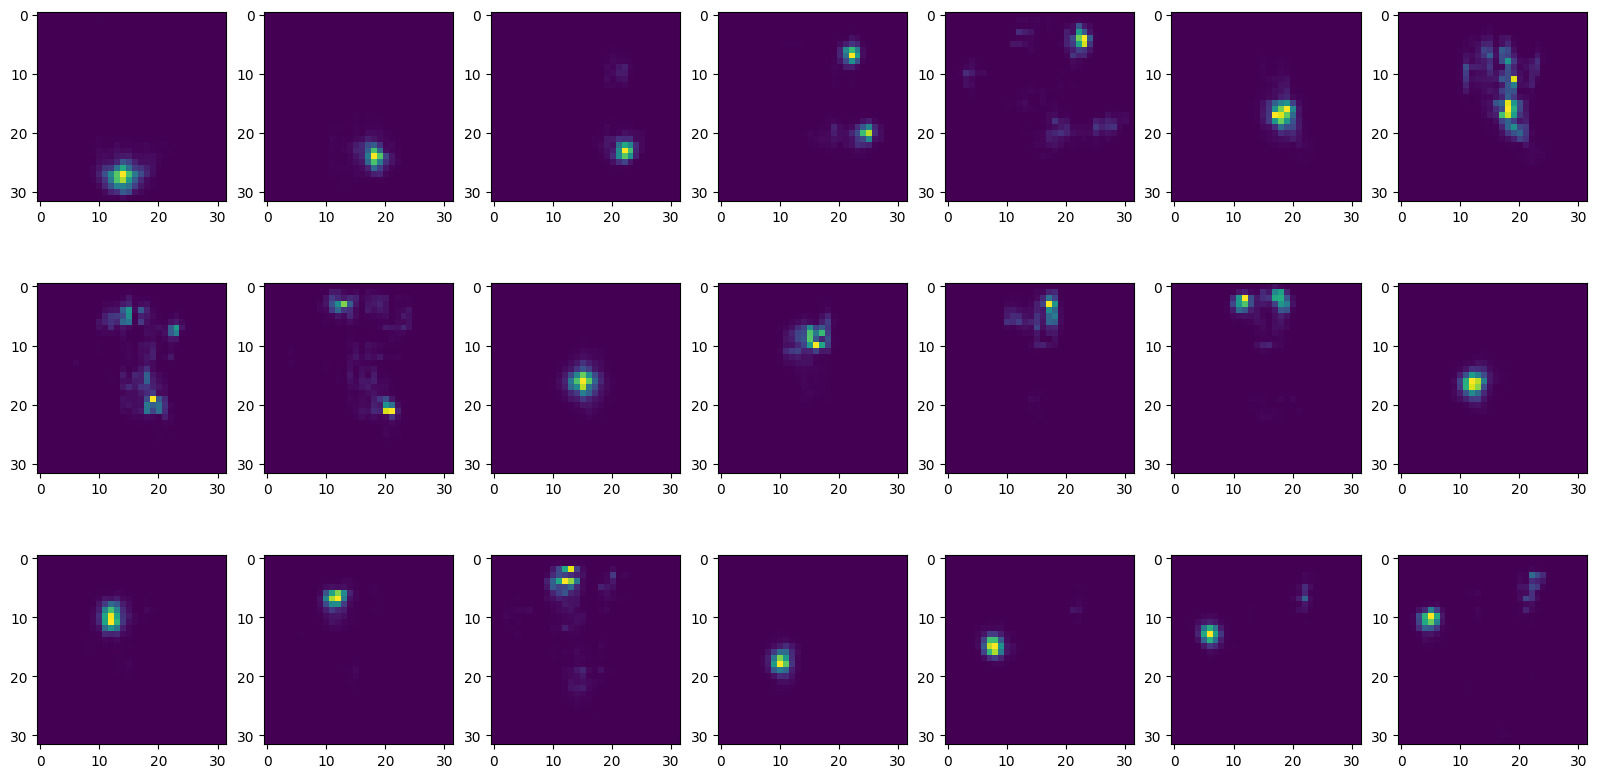

In [ ]:
#Image to model
ph1_net = model(img1t)

Post-procesamiento

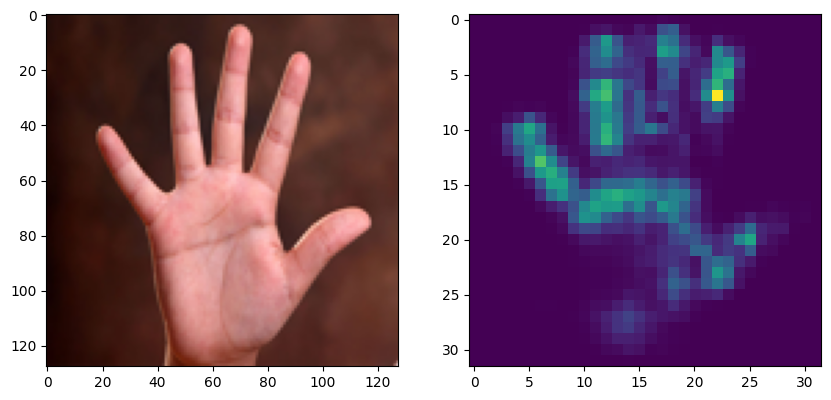

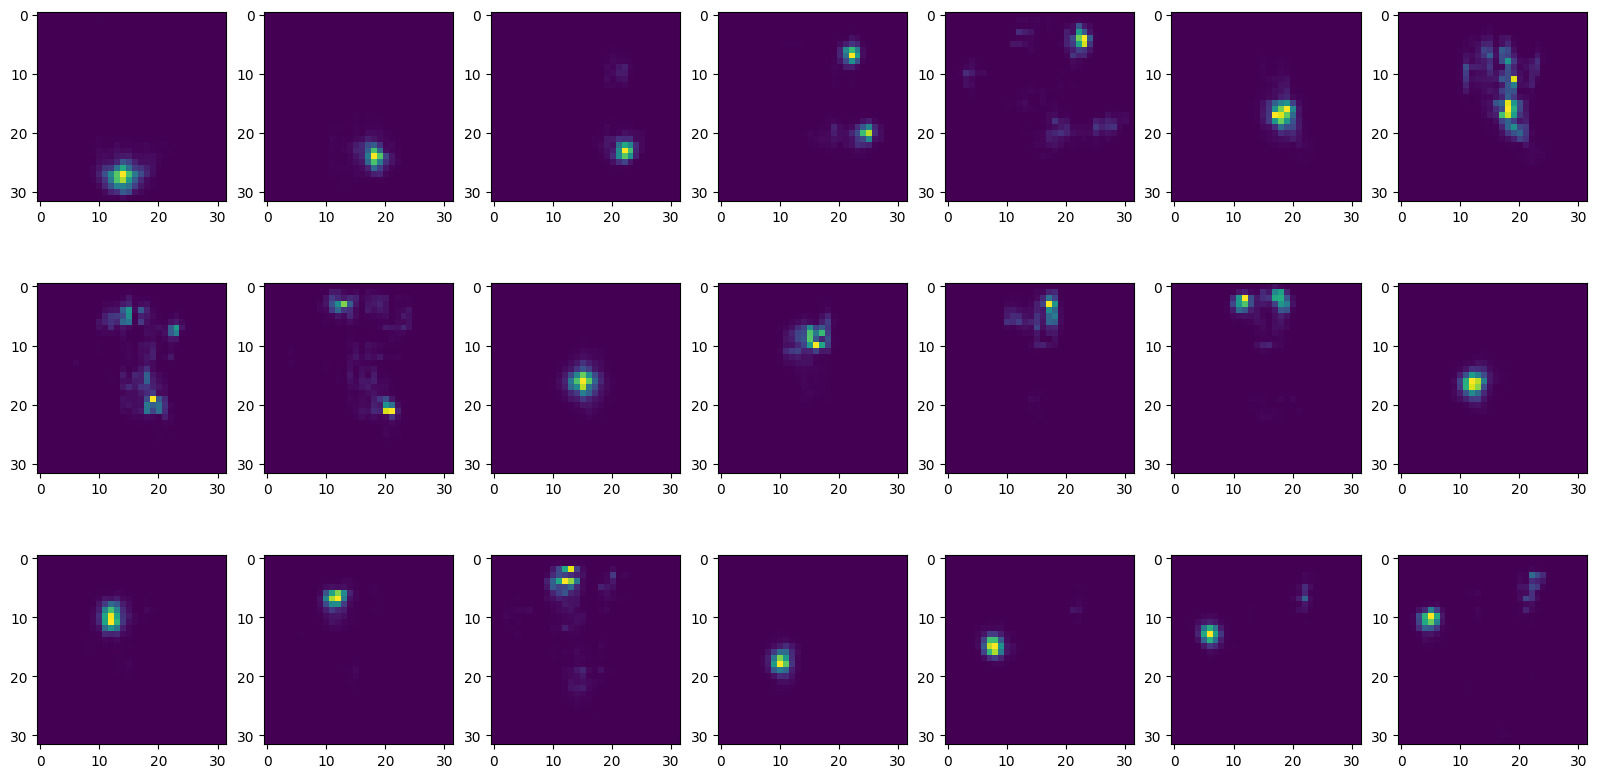

In [74]:
#Process heatmaps
ph1 = ph1_net['h_map'].detach().numpy()

#Generate a single image
ph1_full = np.zeros([ph1.shape[2], ph1.shape[3]])
for i in range(ph1.shape[1]):

  ph1_full += ph1[0, i, :, :]

#Print headmaps
plt.figure(1, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(ph1_full)
plt.show()

plt.figure(3, figsize=(20, 10))
for i in range(ph1.shape[1]):

  plt.subplot(3, 7, i + 1)
  plt.imshow(ph1[0, i, :, :])

plt.show()

5.- Convertir a ONNX y OpenVINO

In [ ]:
#Importat herramientas
import torch.onnx

#Entrada generica del modelo
x = torch.randn(1, 3, 128, 128, requires_grad=True)
torch_out = model(x)

#Crear directorio de modelos
!mkdir models

#Exportar modelo
torch.onnx.export(model,               # Modelo a convertir
                  x,                         # Entrada generica
                  "models/hand_network.onnx",   # Destino del modelo
                  export_params=True,        # Exportar pesos en el mismo archivo
                  opset_version=11,          # Version de ONNX a exportar
                  do_constant_folding=True,  # Ejecutar optimizacion de parametros
                  input_names = ['input'],   # Entradas del modelo
                  output_names = ['h_map', 'd_map', 'l_map', 'delta', 'xyz', 'uv']) # Salidas del modelo


In [41]:
#Convertir modelo a OpenVINO
ov_model = ov.convert_model('models/hand_network.onnx')
ov.save_model(ov_model, 'models/hand_network.xml')

### **5.- Inferencia en ONNX**

Importar modelo

In [75]:
#Cargar modelo
ort_session = ort.InferenceSession("models/hand_network.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy()# if tensor.requires_grad else tensor.cpu().numpy()

Inferencia

In [76]:
#Procesar entrada con ONNX
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img1t)}
ort_outs = ort_session.run(None, ort_inputs)

Post-procesamiento

Salidas: 
(1, 21, 32, 32)
(1, 21, 3, 32, 32)
(1, 21, 3, 32, 32)
(1, 21, 3)
(1, 21, 3)
(1, 21, 2)


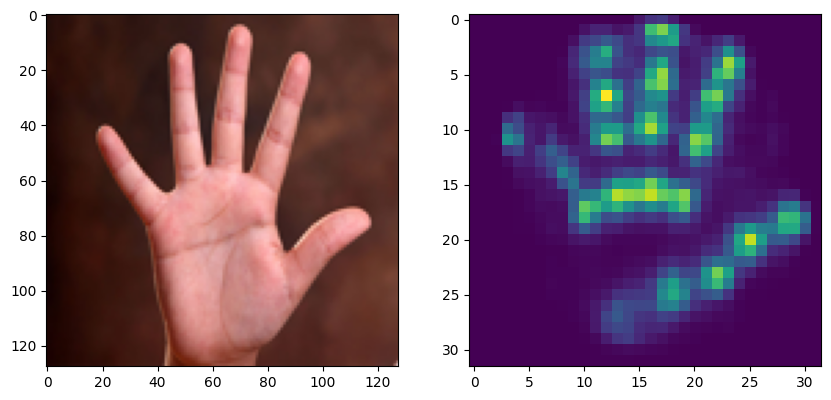

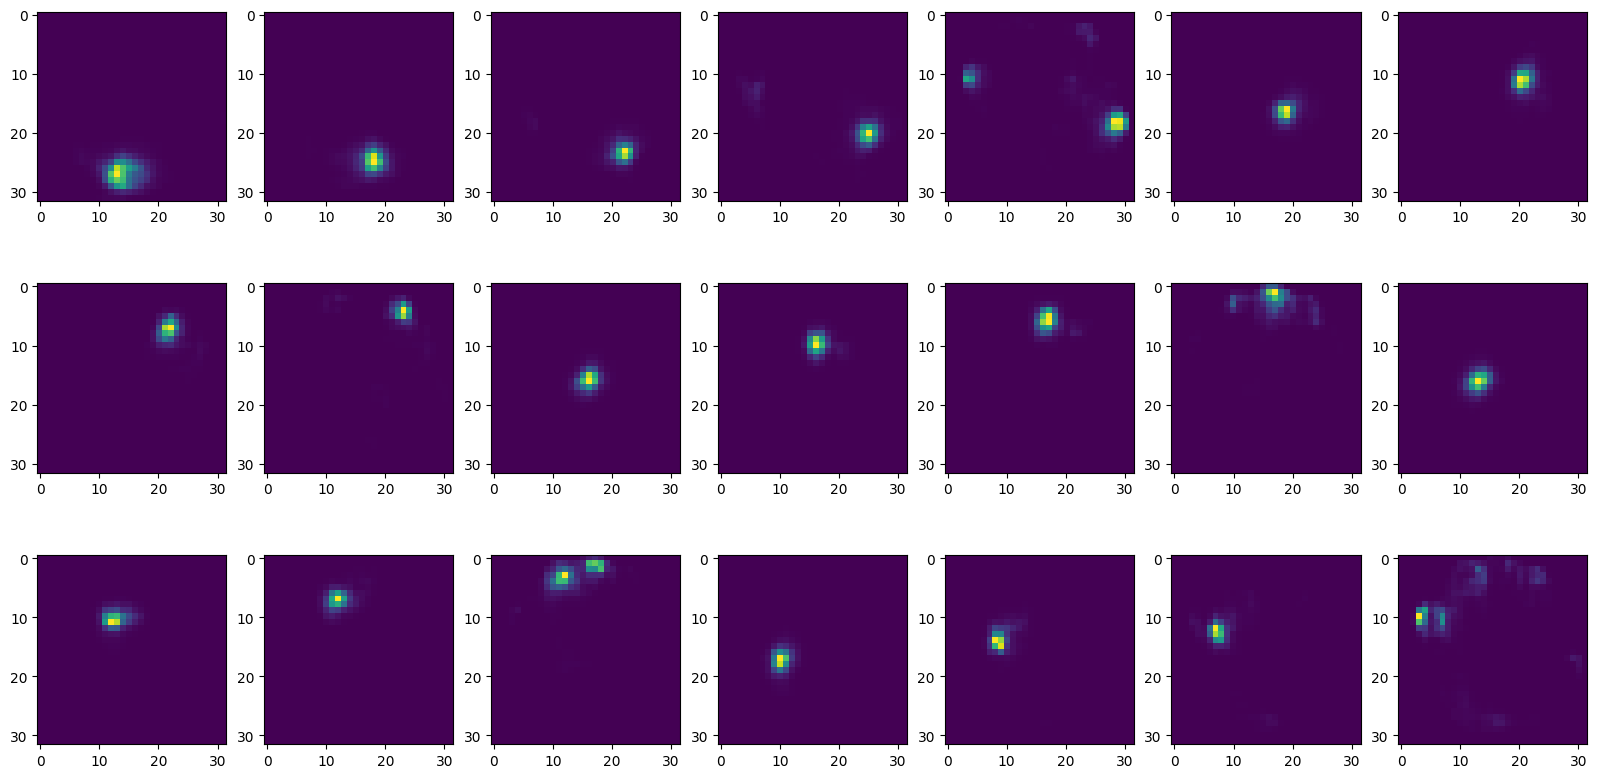

In [77]:
print("Salidas: ")
for i in range(len(ort_outs)):
  print(ort_outs[i].shape)

#Extraer mapas de calor
heatmaps_onnx = np.array(ort_outs[0][0])
onnx_img = np.zeros([32, 32], dtype='float')

#Extraer mapas
for i in range(heatmaps_onnx.shape[0]):

  onnx_img += heatmaps_onnx[i, :, :]

#Mostrar mapas
plt.figure(1, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(onnx_img)
plt.show()

plt.figure(3, figsize=(20, 10))
for i in range(ph1.shape[1]):

  plt.subplot(3, 7, i + 1)
  plt.imshow(heatmaps_onnx[i, :, :])

plt.show()

### **6.-Inferencia con OpenVINO**

In [78]:
#Cargar modelo
def load_IR_to_IE(model_xml, model_bin, mode):

  #Inicializar plugin
  plugin = ov.Core()

  #Cargar modelo
  net = plugin.read_model(model=model_xml)

  #Configurar dispositivo de ejecucion
  if(mode == 0):
    exec_net = plugin.compile_model(net, device_name="CPU")
    print("Modelo cargado: " + str(model_xml) + " (CPU)")
  elif(mode == 1):
    exec_net = plugin.compile_model(net, device_name="GPU")
    print("Modelo cargado: " + str(model_xml) + " (GPU)")
  elif(mode == 2):
    exec_net = plugin.compile_model(net, device_name="MYRIAD")
    print("Modelo cargado: " + str(model_xml) + " (MYRIAD)")
  elif(mode == 3):
    exec_net = plugin.compile_model(net, device_name="VPU")
    print("Modelo cargado: " + str(model_xml) + " (VPU)")

  return exec_net

Cargar modelo

In [79]:
#Ruta del modelo
model_xml = "/content/Minimal-Hand-pytorch/models/hand_network.xml"

#Load openvino model
model_ov = load_IR_to_IE(model_xml, model_xml[:-3] + "bin", 0)

Modelo cargado: /content/Minimal-Hand-pytorch/models/hand_network.xml (CPU)


Preprocesamiento

In [80]:
#Preprocesar imagen
img_prep = np.float32(img1)/255.0 - 0.5
img_prep = np.transpose(img_prep, (2, 0, 1))
img_prep = np.expand_dims(img_prep, axis=0)

Inferencia

In [81]:
#Ejecutar modelo
result = model_ov(img_prep)

Post-procesamiento

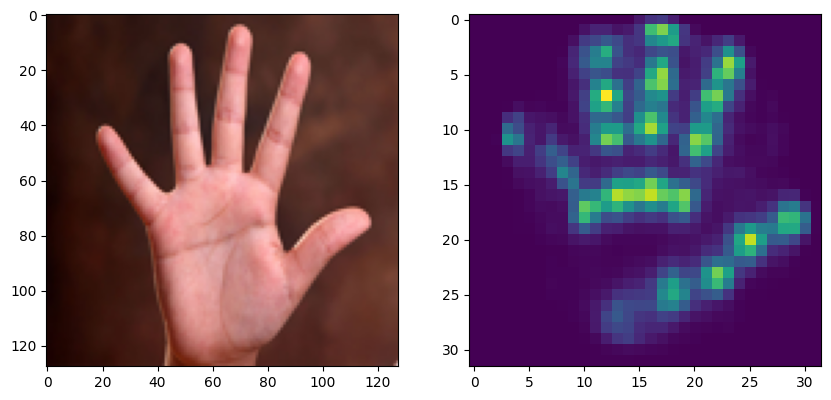

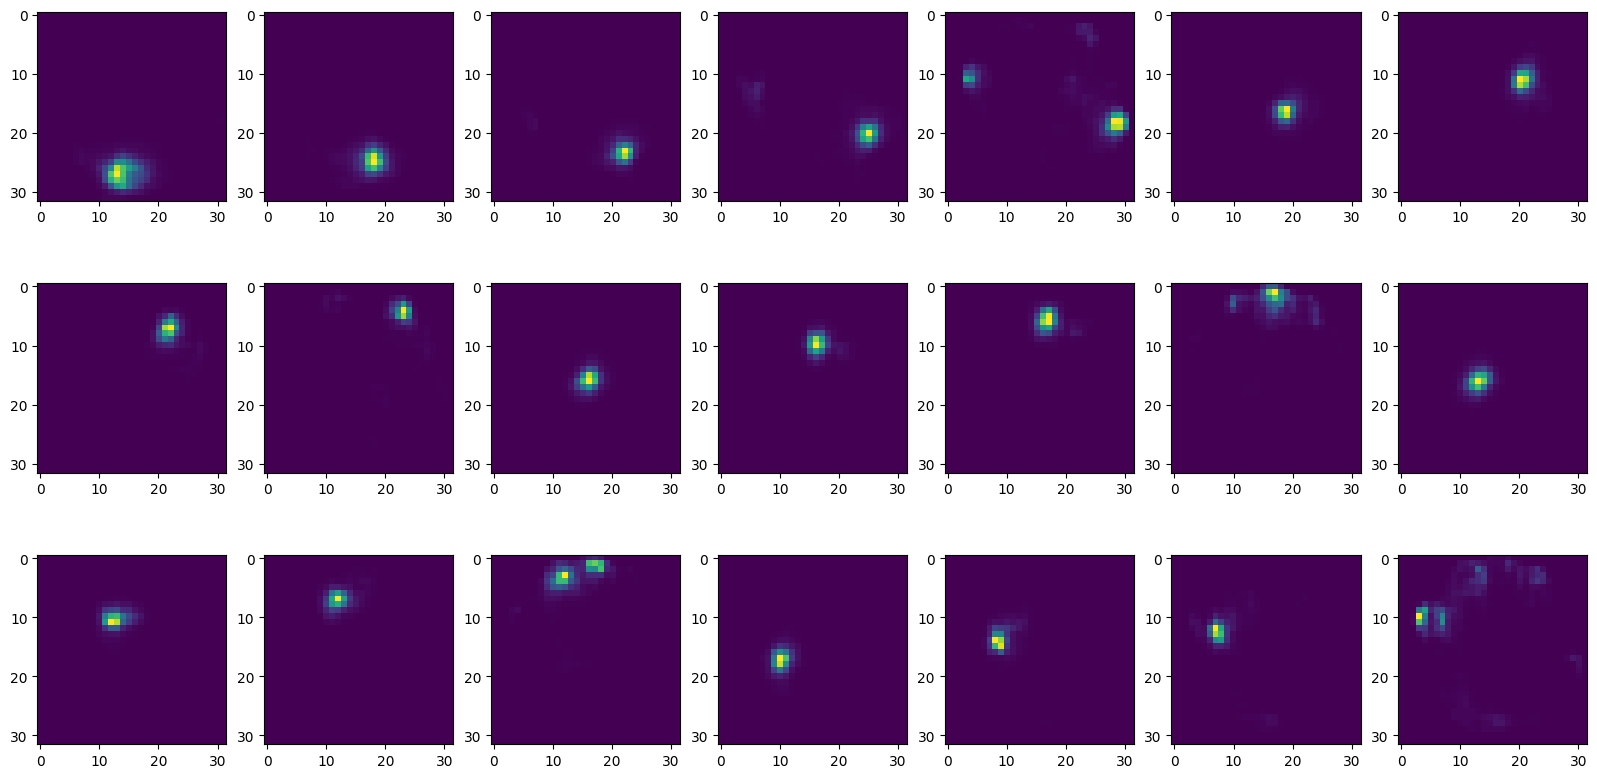

In [82]:
#Extraer mapas
heatmaps_ov = np.array(result[0][0])
ov_img = np.zeros([32, 32], dtype='float')
for i in range(heatmaps_ov.shape[0]):

  ov_img += heatmaps_ov[i, :, :]

#Imprimir mapas
plt.figure(1, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(ov_img)
plt.show()

plt.figure(3, figsize=(20, 10))
for i in range(ph1.shape[1]):

  plt.subplot(3, 7, i + 1)
  plt.imshow(heatmaps_ov[i, :, :])

plt.show()

  ### **7.- Comparativa de frameworks**

In [73]:
import timeit

#Pytorch
t0 = timeit.default_timer()
ph1_net = model(img1t)
print("Inferencia en pytorch: " + str(timeit.default_timer() - t0))

#ONNX
t0 = timeit.default_timer()
ort_outs = ort_session.run(None, ort_inputs)
print("Inferencia en pytorch: " + str(timeit.default_timer() - t0))

#OpenVINO
t0 = timeit.default_timer()
result = model_ov(img_prep)
print("Inferencia en pytorch: " + str(timeit.default_timer() - t0))

Inferencia en pytorch: 0.5253696050003782
Inferencia en pytorch: 0.4009211739994498
Inferencia en pytorch: 0.3868307709999499
